<a href="https://colab.research.google.com/github/zrruziev/Deep_Learning_Practice/blob/main/TDC/C4_W4_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

##Utilities

In [26]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

##Generate the Synthetic Data

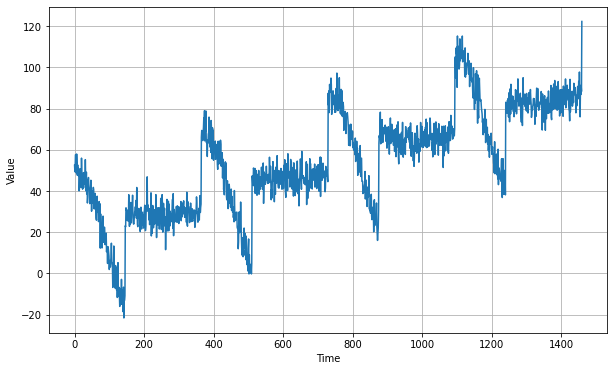

In [27]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, xlabel='Time', ylabel='Value')

##Split the Dataset

In [28]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

##Prepare Features and Labels

In [29]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [30]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [31]:
# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

##Build the Model

In [32]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 32)            128       
                                                                 
 lstm (LSTM)                 (None, 30, 32)            8320      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_________________________________________________________________


##Tune the Learning Rate
In the previous labs, you are using different models for tuning and training. That is a valid approach but you can also use the same model for both. Before tuning, you can use the get_weights() method so you can reset it later.

In [33]:
# Get initial weights
init_weights = model.get_weights()

In [36]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 9s 22ms/step - loss: 72.8379 - mae: 73.3379 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 72.5487 - mae: 73.0487 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 72.1990 - mae: 72.6990 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 71.8052 - mae: 72.3052 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 71.3646 - mae: 71.8646 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 70.8712 - mae: 71.3712 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 70.3181 - mae: 70.8181 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 16ms/step - loss: 69.6984 - mae: 70.1984 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 16ms/step - loss: 69.0052 - mae:

(1e-08, 0.001, 0.0, 60.0)

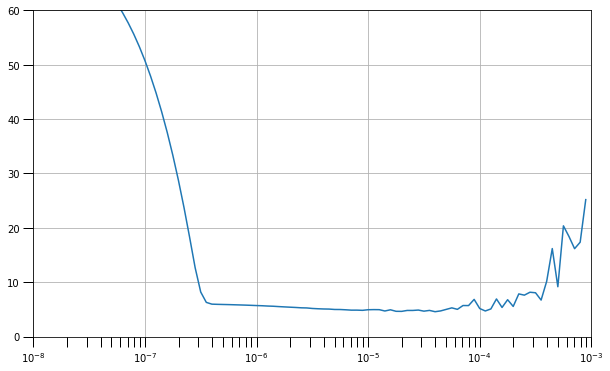

In [44]:
# Set the figure size
plt.figure(figsize=(10,6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(history.history["lr"], history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 60])

##Train the Model

In [45]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [46]:
# Set the learning rate
learning_rate = 2e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [47]:
# Train the model
history = model.fit(train_set,epochs=500)

Epoch 1/500
31/31 [==============================] - 5s 17ms/step - loss: 22.0301 - mae: 22.5247
Epoch 2/500
31/31 [==============================] - 1s 16ms/step - loss: 13.5440 - mae: 14.0358
Epoch 3/500
31/31 [==============================] - 1s 15ms/step - loss: 11.3363 - mae: 11.8254
Epoch 4/500
31/31 [==============================] - 1s 16ms/step - loss: 9.9063 - mae: 10.3930
Epoch 5/500
31/31 [==============================] - 1s 16ms/step - loss: 8.8340 - mae: 9.3158
Epoch 6/500
31/31 [==============================] - 1s 16ms/step - loss: 8.1013 - mae: 8.5842
Epoch 7/500
31/31 [==============================] - 1s 15ms/step - loss: 7.6805 - mae: 8.1635
Epoch 8/500
31/31 [==============================] - 1s 16ms/step - loss: 7.3387 - mae: 7.8185
Epoch 9/500
31/31 [==============================] - 1s 16ms/step - loss: 7.0998 - mae: 7.5791
Epoch 10/500
31/31 [==============================] - 1s 16ms/step - loss: 6.9369 - mae: 7.4164
Epoch 11/500
31/31 [======================

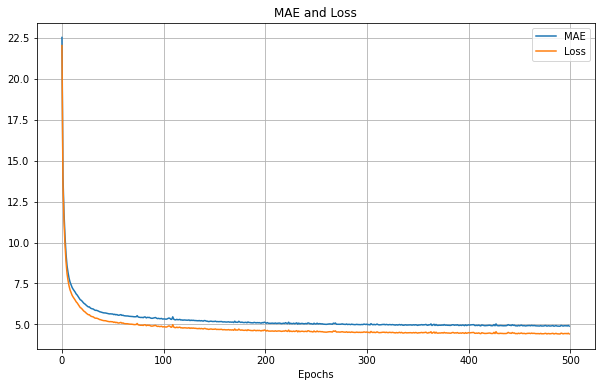

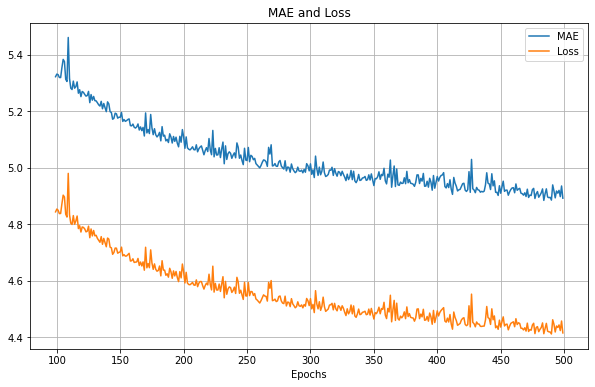

In [52]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )



# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

##Model Prediction

In [53]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

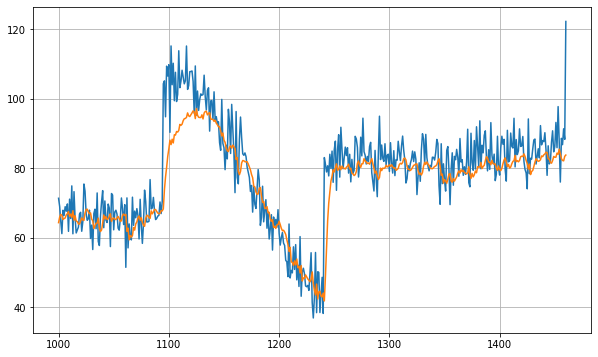

In [54]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [55]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

62.44861
5.672717


##Optional - Adding a Callback for Early Stopping

In [64]:
# Generate data windows from the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [65]:
# Uncomment if you want to reset the weights
model.set_weights(init_weights)

In [66]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when a certain metric is met

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the validation set MAE
    if(logs.get('val_mae') < 5.2):

      # Stop if threshold is met
      print("\nRequired val MAE is met so cancelling training!")
      self.model.stop_training = True

# Instantiate the class
callbacks = myCallback()

In [67]:
# Set the learning rate
learning_rate = 1e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=500, validation_data=val_set, callbacks=[callbacks])

Epoch 1/500
31/31 [==============================] - 6s 51ms/step - loss: 12.9718 - mae: 13.4617 - val_loss: 15.9064 - val_mae: 16.4035
Epoch 2/500
31/31 [==============================] - 1s 21ms/step - loss: 7.2621 - mae: 7.7476 - val_loss: 13.5449 - val_mae: 14.0369
Epoch 3/500
31/31 [==============================] - 1s 21ms/step - loss: 6.0857 - mae: 6.5695 - val_loss: 9.9469 - val_mae: 10.4386
Epoch 4/500
31/31 [==============================] - 1s 21ms/step - loss: 5.3360 - mae: 5.8165 - val_loss: 10.3369 - val_mae: 10.8271
Epoch 5/500
31/31 [==============================] - 1s 21ms/step - loss: 5.7290 - mae: 6.2089 - val_loss: 7.6312 - val_mae: 8.1171
Epoch 6/500
31/31 [==============================] - 1s 21ms/step - loss: 5.3113 - mae: 5.7923 - val_loss: 8.2948 - val_mae: 8.7861
Epoch 7/500
31/31 [==============================] - 1s 21ms/step - loss: 5.7101 - mae: 6.1925 - val_loss: 12.1878 - val_mae: 12.6824
Epoch 8/500
31/31 [==============================] - 1s 21ms/step

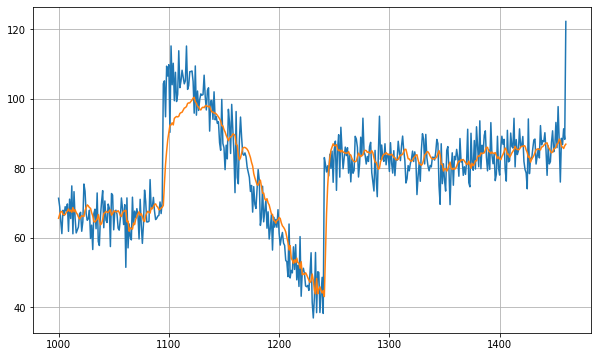

In [69]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [70]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

49.16124
5.0738964
